# WebRender dashboard ETL script

You probably want to look at the [published dashboard](file:///Users/tsmith/projects/webrender-dashboard/dashboard.html).

You can check [scheduled run status](https://dbc-caf9527b-e073.cloud.databricks.com/#job/715).


### What's different?

* Metrics are summarized by build (vs date).
* Performance metrics are aggregated over users; this is important because it reduces the impacts of outlier users on our understanding of product performance, and because it reflects how WebRender changes the user experience at the user level.
* Pings are artisanally hand-selected so that comparisons between experiment branches are fair even in the presence of the various enrollment weirdnesses.

In [2]:
%r
library(boot)
library(dplyr, warn.conflicts=FALSE)
library(ggplot2)
library(sparklyr, warn.conflicts=FALSE)
library(tidyr, warn.conflicts=FALSE)

sc = spark_connect(method="databricks")

# Save result tables so we can access them from hala
final_outdb_path = "/dbfs/tdsmith/webrender.sqlite3"

In [3]:
from moztelemetry.dataset import Dataset
import pandas as pd
from pyspark.sql import Row
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, BooleanType, IntegerType, DoubleType, LongType, MapType
from statsmodels.stats.weightstats import DescrStatsW

EXPERIMENT_ID = "prefflip-webrender-v1-2-1492568"
EXPERIMENT_ID_2 = "prefflip-webrender-v1-3-1492568"
PARTITIONS = [s.replace("-", "_") for s in (EXPERIMENT_ID, EXPERIMENT_ID_2)]

In [4]:
to_summarize = {
  "composite_time": "payload.processes.gpu.histograms.COMPOSITE_TIME",
  "content_frame_time": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME",
  "content_frame_time_vsync": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME_VSYNC",
  "content_paint_time": "payload.processes.content.histograms.CONTENT_PAINT_TIME",
  "tab_switch_composite": "payload.histograms.FX_TAB_SWITCH_COMPOSITE_E10S_MS",
  "content_full_paint_time": "payload.processes.gpu.histograms.CONTENT_FULL_PAINT_TIME",
  "page_load_ms": "payload.histograms.FX_PAGE_LOAD_MS_2"
}

to_pull = {}
for k, v in to_summarize.items():
  to_pull[k] = v + ".values"
  to_pull[k + "_sum"] = v + ".sum"

pings = (
  Dataset
  .from_source("telemetry-cohorts")
  .where(
    docType="main",
    experimentId=lambda x: x in PARTITIONS,
    submissionDate=lambda x: int(x) >= 20190108,
#    appBuildId='20190104093221',
  )
  .select(
    app_build_id="application.buildId",
    branch='environment.experiments."%s".branch' % EXPERIMENT_ID,
    branch2='environment.experiments."%s".branch' % EXPERIMENT_ID_2,
    client_id="clientId",
    gfx_info='environment.system.gfx',
    gfx_compositor="environment.system.gfx.features.compositor",
    normalized_channel="meta.normalizedChannel",
    profile_subsession_counter="payload.info.profileSubsessionCounter",
    session_id="payload.info.sessionId",
    target_pref_value='environment.settings.userPrefs."gfx.webrender.all.qualified"',
    # ---
    device_reset_reason_content="payload.processes.content.histograms.DEVICE_RESET_REASON.values",
    device_reset_reason_gpu="payload.processes.gpu.histograms.DEVICE_RESET_REASON.values",
    device_reset_reason_parent="payload.histograms.DEVICE_RESET_REASON.values",
    subsession_length="payload.info.subsessionLength",
    active_ticks='payload.processes.parent.scalars."browser.engagement.active_ticks"',
    total_uris='payload.processes.parent.scalars."browser.engagement.total_uri_count"',
    **to_pull
  )
  .records(sc)
)

def ping_to_row(x):
  for k, v in to_summarize.items():
    x[k + "_count"] = sum((x[k] or {}).values())
  
  x["experiment"] = (x["branch"] and 2) or 3
  x["branch"] = x["branch"] or x["branch2"]
  del x["branch2"]
  
  # Aggregate DEVICE_RESET_REASON for crash rates
  procs = ("parent", "content", "gpu")
  x["device_reset_reason_total"] = 0
  for proc in procs:
    key = "device_reset_reason_" + proc
    x[key + "_count"] = sum((x[key] or {}).values())
    x["device_reset_reason_total"] += x[key + "_count"]
    del x[key]
  
  # Calculate usage hours for crash rates
  # Based on https://github.com/mozilla/telemetry-streaming/blob/ee2eafd18a8b12a3fafca496d58789f641069bf6/src/main/scala/com/mozilla/telemetry/pings/MainPing.scala#L71-L82
  subsession_length = x["subsession_length"] or 0
  x["usage_hours"] = max(min(subsession_length/3600., 25.), 0.)
  return Row(**x)

fetching 16050.89859MB in 4803 files...

In [5]:
single_pings = pings.filter(lambda p: len(p['gfx_info']['adapters']) == 1)

In [6]:
nvpings = single_pings.filter(lambda p: p['gfx_info']['adapters'][0]['vendorID'] == '0x10de')

In [7]:
k = single_pings.take(1)[0]

In [8]:
import json
import urllib2
gpu_db = json.load(urllib2.urlopen('https://raw.githubusercontent.com/jrmuizel/gpu-db/master/nvidia.json'))
devices = {}
for gen in gpu_db['10de'].items():
    for chipset in gen[1].items():
        for dev in chipset[1]:
            #print dev, gen[0]
            devices[int(dev,16)] = gen[0]

In [9]:
  
devices[int(k['gfx_info']['adapters'][0]['deviceID'],16)]

Out[ 7 ]: u'Fermi'

In [10]:
print "erhd"
print "dodf"

erhd
dodf

In [11]:
def gen_map(p):
  try:
    p['gen'] = devices[int(p['gfx_info']['adapters'][0]['deviceID'],16)]

  except:
    if not p['gfx_info']['adapters'][0]['deviceID']:
      p['gen'] = 'nodevice'
    elif not p['gfx_info']['adapters'][0]['vendorID']:
      p['gen'] = 'novendor'
    else:
      p['gen'] = p['gfx_info']['adapters'][0]['vendorID'] + ' ' + p['gfx_info']['adapters'][0]['deviceID']
  return p
genpings = nvpings.map(gen_map)
genpings.map(lambda p: p['gen']).countByValue()

Out[ 9 ]: defaultdict(<type 'int'>, {u'Tesla': 9469, u'Maxwell': 102946, u'Pascal': 187680, u'Kepler': 77756, u'Fermi': 48434, u'Turing': 5391})

In [12]:
pings = genpings.filter(lambda p: len(p["gfx_info"]["monitors"]) == 1 and p["gfx_info"]["monitors"][0]["refreshRate"] == 60)

In [13]:
sdf_fields = [
  StructField("app_build_id", StringType(), True),
  StructField("branch", StringType(), False),
  StructField("client_id", StringType(), False),
  StructField("experiment", IntegerType(), False),
  StructField("gfx_compositor", StringType(), True),
  StructField("normalized_channel", StringType(), True),
  StructField("profile_subsession_counter", LongType(), True),  
  StructField("session_id", StringType(), True),
  StructField("gen", StringType(), True),
  StructField("target_pref_value", BooleanType(), True),
  StructField("device_reset_reason_parent_count", LongType(), True),
  StructField("device_reset_reason_content_count", LongType(), True),
  StructField("device_reset_reason_gpu_count", LongType(), True),
  StructField("device_reset_reason_total", LongType(), True),
  StructField("active_ticks", LongType(), True),
  StructField("total_uris", LongType(), True),
  StructField("subsession_length", LongType(), True),
  StructField("usage_hours", DoubleType(), True),
]

for k, v in to_summarize.items():
  sdf_fields.extend([
    StructField(k, MapType(StringType(), LongType()), True),
    StructField(k + "_sum", LongType(), True),
    StructField(k + "_count", LongType(), True),
  ])

sdf = spark.createDataFrame(pings.map(ping_to_row), schema=StructType(sdf_fields))

In [14]:
sdf.cache()
None

In [15]:
# Because compositor changes don't take effect until the browser restarts,
# we should discard the enrollment session we observe for each client.
# We'll find those sessions here, and then anti-join against this table later.

first_sessions = (
  sdf
  .orderBy(sdf.experiment, sdf.client_id, sdf.branch, sdf.profile_subsession_counter)
  .groupBy(sdf.experiment, sdf.client_id, sdf.branch)
  .agg(
    f.first(sdf.session_id).alias("session_id"),
  )
)

In [16]:
# Broadcast joins time-out unless the cluster is warm
spark.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

subsessions = (
  sdf
  .join(first_sessions, on=["experiment", "client_id", "branch", "session_id"], how="left_anti")
  .where(sdf.target_pref_value.isNotNull())
  .where(
    ((sdf.branch == "disabled") & (sdf.gfx_compositor == "d3d11"))
    | ((sdf.branch == "enabled") & (sdf.gfx_compositor == "webrender"))
  )
  .where(
    #(sdf.normalized_channel == "beta") | 
    (sdf.normalized_channel == "nightly")
  )
  .filter("app_build_id >= '20190104093221'")
  #.filter("app_build_id >= '20190107214730'")

  .cache()
)

In [17]:
sorted(subsessions.filter("normalized_channel != 'beta'").select('app_build_id').rdd.map(lambda x: x['app_build_id']).countByValue().items())

Out[ 15 ]: 
[(u'20190104093221', 84),
 (u'20190104132412', 30),
 (u'20190104214806', 90),
 (u'20190105123739', 44),
 (u'20190105215256', 81),
 (u'20190106095006', 171),
 (u'20190106214444', 220),
 (u'20190107093040', 574),
 (u'20190107214730', 790),
 (u'20190108101613', 2223),
 (u'20190108215840', 2672),
 (u'20190109092644', 2007),
 (u'20190109163702', 1132),
 (u'20190109214248', 2342),
 (u'20190110093854', 3364),
 (u'20190110214210', 1576),
 (u'20190111093148', 2858),
 (u'20190111215452', 2228),
 (u'20190112094119', 2717),
 (u'20190112213654', 2337),
 (u'20190113100555', 2294),
 (u'20190113213646', 480),
 (u'20190114014511', 1016),
 (u'20190114104248', 599)]

In [18]:
subsessions.createOrReplaceGlobalTempView("webrender_metrics")

In [19]:
# Compute per-user quantiles for CONTENT_PAINT_TIME

def generate_quantile_udf(sdf, grouping_fields, bucket_field, count_field, quantiles):
  """
  sdf: Spark DataFrame
  grouping_fields: list of strings representing columns from sdf
  bucket_field: Name of the field containing histogram buckets
  count_field: Name of the field containing counts
  quantiles: List of quantiles as floating point values on [0, 1]
  """
  schema = (
    sdf
    .select(*grouping_fields)
    .schema
    .add(StructField("quantile", DoubleType(), False))
    .add(StructField("value", DoubleType(), True))
  )
  
  @f.pandas_udf(schema, f.PandasUDFType.GROUPED_MAP)
  def udf(df):
    stats = DescrStatsW(df[bucket_field].astype(float), df[count_field]).quantile(quantiles)
    stats = stats.rename_axis("quantile").reset_index(name="value").assign(_dummy=1)
    grouping_variables = df[grouping_fields].iloc[:1].assign(_dummy=1)
    result = grouping_variables.merge(stats, on="_dummy").drop("_dummy", axis=1)
    return result
  
  return udf

metric_quantiles = generate_quantile_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  quantiles=[0.5, 0.9, 0.95, 0.99]
)

paint_time_quantiles = (
  subsessions
  .select(
    subsessions.client_id,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_paint_time).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel, "bucket")
  .agg(f.sum("count").alias("count"))
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
  .apply(metric_quantiles)
)

paint_time_quantiles.createOrReplaceGlobalTempView("wr_paint_time_quantiles")

In [20]:
# Changes to CONTENT_FRAME_TIME are only user-visible when CONTENT_FRAME_TIME exceeds 200.
# Count the fraction of CONTENT_FRAME_TIME events where the threshold is exceeded.
# (The threshold is set to 192 because of the binning of the histogram.)

def generate_threshold_udf(sdf, grouping_fields, bucket_field, count_field, thresholds):
  """
  sdf: Spark DataFrame
  grouping_fields: list of strings representing columns from sdf
  bucket_field: Name of the field containing histogram buckets
  count_field: Name of the field containing counts
  thresholds: List of thresholds. Should probably align on the left edge of a bucket.
  """
  schema = (
    sdf
    .select(*grouping_fields)
    .schema
    .add(StructField("threshold", IntegerType(), False))
    .add(StructField("fraction_exceeding", DoubleType(), True))
  )
  
  @f.pandas_udf(schema, f.PandasUDFType.GROUPED_MAP)
  def udf(df):
    rows = []
    all_sum = float(df[count_field].sum())
    for tx in thresholds:
      fraction = df.loc[df[bucket_field].astype(int) >= tx, count_field].sum() / all_sum
      rows.append({"threshold": tx, "fraction_exceeding": fraction})
    data = pd.DataFrame(rows).assign(_dummy=1)
    grouping_variables = df[grouping_fields].iloc[:1].assign(_dummy=1)
    result = grouping_variables.merge(data, on="_dummy").drop("_dummy", axis=1)
    return result
  
  return udf

vsync_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[192],
)

slow_content_frame_time = (
  subsessions
  .select(
    subsessions.client_id,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_frame_time).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
  .apply(vsync_threshold)
)

slow_content_frame_time.createOrReplaceGlobalTempView("wr_slow_content_frame_time")

In [21]:
# Changes to CONTENT_FRAME_TIME_VSYNC are only user-visible when CONTENT_FRAME_TIME_VSYNC exceeds 200.
# Count the fraction of CONTENT_FRAME_TIME_VSYNC events where the threshold is exceeded.

vsync_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel", "gen"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[200],
)

slow_content_frame_time_vsync = (
  subsessions
  .select(
    subsessions.client_id,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    subsessions.gen,
    f.explode(subsessions.content_frame_time_vsync).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
  .apply(vsync_threshold)
)

slow_content_frame_time_vsync.createOrReplaceGlobalTempView("wr_slow_content_frame_time_vsync")
slow_content_frame_time_vsync.count()

Out[ 19 ]: 9130

In [22]:
sorted(slow_content_frame_time_vsync.select('app_build_id').rdd.countByValue().items())

Out[ 20 ]: 
[(Row(app_build_id=u'20190104093221'), 23),
 (Row(app_build_id=u'20190104132412'), 11),
 (Row(app_build_id=u'20190104214806'), 23),
 (Row(app_build_id=u'20190105123739'), 16),
 (Row(app_build_id=u'20190105215256'), 30),
 (Row(app_build_id=u'20190106095006'), 55),
 (Row(app_build_id=u'20190106214444'), 84),
 (Row(app_build_id=u'20190107093040'), 238),
 (Row(app_build_id=u'20190107214730'), 263),
 (Row(app_build_id=u'20190108101613'), 573),
 (Row(app_build_id=u'20190108215840'), 691),
 (Row(app_build_id=u'20190109092644'), 628),
 (Row(app_build_id=u'20190109163702'), 348),
 (Row(app_build_id=u'20190109214248'), 674),
 (Row(app_build_id=u'20190110093854'), 859),
 (Row(app_build_id=u'20190110214210'), 507),
 (Row(app_build_id=u'20190111093148'), 727),
 (Row(app_build_id=u'20190111215452'), 689),
 (Row(app_build_id=u'20190112094119'), 727),
 (Row(app_build_id=u'20190112213654'), 654),
 (Row(app_build_id=u'20190113100555'), 611),
 (Row(app_build_id=u'20190113213646'), 169),
 (Row(app_build_id=u'20190114014511'), 326),
 (Row(app_build_id=u'20190114104248'), 204)]

In [23]:
# Summarize instances of other performance metrics exceeding 16ms

# to_summarize = {
#   "composite_time": "payload.processes.gpu.histograms.COMPOSITE_TIME",
#   "content_paint_time": "payload.processes.content.histograms.CONTENT_PAINT_TIME",
#   "content_full_paint_time": "payload.processes.gpu.histograms.CONTENT_FULL_PAINT_TIME",
# }

time_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[16],
)

time_threshold_histograms = ["composite_time", "content_paint_time", "content_full_paint_time"]
for h in time_threshold_histograms:
  slow_df = (
    subsessions
    .select(
      subsessions.client_id,
      subsessions.branch,
      subsessions.normalized_channel,
      subsessions.app_build_id,
      f.explode(h).alias("bucket", "count")
    )
    .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
    .apply(time_threshold)
  )
  slow_df.createOrReplaceGlobalTempView("wr_slow_%s" % h)

## Performance metrics

Error bars are 95% confidence intervals for the central parameter of the per-user aggregate assuming a log-normal population distribution.

In [25]:
%r
metrics = tbl(sc, "global_temp.webrender_metrics")
per_user_build = metrics %>%
  select(app_build_id, normalized_channel, branch, client_id, ends_with("_count"), ends_with("_sum")) %>%
  select(-starts_with("device_reset_reason")) %>%
  group_by(app_build_id, normalized_channel, branch, client_id) %>%
  summarize_all(sum) %>%
  collect %>%
  gather("metric", "value", ends_with("_count"), ends_with("_sum")) %>%
  separate(metric, c("metric", "agg"), sep="_(?!.*_)") %>%
  spread(agg, value) %>%
  mutate(mean=sum/count)

In [26]:
%r
perf_medians = per_user_build %>%
  group_by(app_build_id, normalized_channel, branch, metric) %>%
  summarize(
    user_median=median(mean, na.rm=TRUE),
    log_sd=sd(log10(mean+1), na.rm=TRUE),
    log_sem=log_sd/sqrt(n()),
    log_ymin=log10(user_median)-1.96*log_sem,
    log_ymax=log10(user_median)+1.96*log_sem
  )

In [27]:
%r
slow_content_frame_time = tbl(sc, "global_temp.wr_slow_content_frame_time") %>% collect

In [28]:
%r
slow_content_frame_boot = function(df) {
  ci = boot(df$fraction_exceeding, function(data, x) median(data[x], na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}

slow_content_frame_time_summary = slow_content_frame_time %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

In [29]:
%r
slow_content_frame_time_vsync = tbl(sc, "global_temp.wr_slow_content_frame_time_vsync")
slow_content_frame_time_vsync

# Source: spark [?? x 7]
 client_id branch app_build_id normalized_chan… gen threshold
 * 
 1 09f60e6b… enabl… 20190109092… nightly Fermi 200
 2 16043be2… enabl… 20190109214… nightly Fermi 200
 3 1993c730… enabl… 20190110093… nightly Pasc… 200
 4 1c072cc2… disab… 20190112213… nightly Pasc… 200
 5 1e17a26e… disab… 20190111215… nightly Pasc… 200
 6 2103e0f7… disab… 20190109092… nightly Maxw… 200
 7 3545d6b5… disab… 20190109092… nightly Maxw… 200
 8 3614a98a… disab… 20190112094… nightly Maxw… 200
 9 411b368e… enabl… 20190111093… nightly Kepl… 200
10 4804a9a0… enabl… 20190107093… nightly Pasc… 200
# ... with more rows, and 1 more variable: fraction_exceeding

In [30]:
%r
slow_content_frame_time_vsync = tbl(sc, "global_temp.wr_slow_content_frame_time_vsync") %>% collect
slow_content_frame_time_vsync_summary = slow_content_frame_time_vsync %>%
  group_by(normalized_channel, branch, app_build_id, gen) %>%
  do(slow_content_frame_boot(.))

[1] "All values of t are equal to 0.170454545454545 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0769109332713169 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.00916112756700067 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0338222967309304 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.029743939246422 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.165817452357071 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.030958230958231 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0168554356550433 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.171823423264821 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.00212135392294494 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0163098878695209 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0177616728050374 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0746606334841629 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0244253859348199 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.154776511831727 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.299772568229531 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.519082633053221 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0786802030456853 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.361702127659574 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.305378414149922 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.136363636363636 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.338978634705576 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0320272572402044 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0286278972270468 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0428571428571429 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.103450527635566 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.020768055158168 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0182218033301916 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0086652912236153 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.174303772466917 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.198794015219915 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.270233535153837 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.209717017702546 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.247373200155662 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.3625 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.178571428571429 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.40260111476347 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0696078431372549 \n Cannot calculate confidence intervals"

In [31]:
%r
nrow(slow_content_frame_time_vsync)

[1] 9130

In [32]:
%r
slow_content_frame_time_vsync_total_summary = slow_content_frame_time_vsync %>%
  group_by(normalized_channel, branch) %>%
  do(slow_content_frame_boot(.))
slow_content_frame_time_vsync_total_summary


# A tibble: 2 x 5
# Groups: normalized_channel, branch [2]
 normalized_channel branch ymin y ymax
 
1 nightly disabled 4.37 4.61 4.82
2 nightly enabled 5.30 5.51 5.72

In [33]:
%r
slow_content_frame_boot_mean = function(df) {
  ci = boot(df$fraction_exceeding, function(data, x) mean(data[x], na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}
slow_content_frame_time_vsync_total_summary = slow_content_frame_time_vsync %>%
  group_by(normalized_channel, branch, gen) %>%
  do(slow_content_frame_boot_mean(.))
slow_content_frame_time_vsync_total_summary

# A tibble: 12 x 6
# Groups: normalized_channel, branch, gen [12]
 normalized_channel branch gen ymin y ymax
 
 1 nightly disabled Fermi 10.8 12.8 14.6 
 2 nightly disabled Kepler 8.76 9.65 10.4 
 3 nightly disabled Maxwell 7.74 8.35 8.91
 4 nightly disabled Pascal 5.84 6.20 6.50
 5 nightly disabled Tesla 7.44 12.6 16.9 
 6 nightly disabled Turing 2.03 3.56 4.66
 7 nightly enabled Fermi 14.9 16.7 18.4 
 8 nightly enabled Kepler 11.5 12.6 13.6 
 9 nightly enabled Maxwell 8.66 9.26 9.85
10 nightly enabled Pascal 7.33 7.72 8.13
11 nightly enabled Tesla 13.1 22.2 31.4 
12 nightly enabled Turing 3.17 3.98 4.78

In [34]:
%r
slow_content_frame_time_total_summary = slow_content_frame_time %>%
  group_by(normalized_channel, branch) %>%
  do(slow_content_frame_boot(.))
slow_content_frame_time_total_summary

# A tibble: 2 x 5
# Groups: normalized_channel, branch [2]
 normalized_channel branch ymin y ymax
 
1 nightly disabled 1.10 1.15 1.21
2 nightly enabled 1.65 1.76 1.83

In [35]:
%r
slow_content_frame_time_vsync %>% filter(branch == 'enabled') %>% summary

client_id branch app_build_id normalized_channel
 Length:4759 Length:4759 Length:4759 Length:4759 
 Class :character Class :character Class :character Class :character 
 Mode :character Mode :character Mode :character Mode :character 
 
 
 
 gen threshold fraction_exceeding
 Length:4759 Min. :200 Min. :0.00000 
 Class :character 1st Qu.:200 1st Qu.:0.02714 
 Mode :character Median :200 Median :0.05506 
 Mean :200 Mean :0.09474 
 3rd Qu.:200 3rd Qu.:0.11386 
 Max. :200 Max. :1.00000

In [36]:
%r
slow_content_frame_time_vsync %>% filter(branch == 'disabled') %>% summary

client_id branch app_build_id normalized_channel
 Length:4371 Length:4371 Length:4371 Length:4371 
 Class :character Class :character Class :character Class :character 
 Mode :character Mode :character Mode :character Mode :character 
 
 
 
 gen threshold fraction_exceeding
 Length:4371 Min. :200 Min. :0.00000 
 Class :character 1st Qu.:200 1st Qu.:0.02045 
 Mode :character Median :200 Median :0.04612 
 Mean :200 Mean :0.07709 
 3rd Qu.:200 3rd Qu.:0.09210 
 Max. :200 Max. :1.00000

In [37]:
%r
slow_content_frame_time_vsync_summary

# A tibble: 203 x 7
# Groups: normalized_channel, branch, app_build_id, gen [203]
 normalized_channel branch app_build_id gen ymin y ymax
 
 1 nightly disabled 20190104093221 Fermi -9.73 3.49 4.68
 2 nightly disabled 20190104093221 Maxwell 1.22 3.81 5.18
 3 nightly disabled 20190104093221 Pascal 0.446 2.22 3.44
 4 nightly disabled 20190104132412 Pascal 1.47 2.33 3.20
 5 nightly disabled 20190104214806 Maxwell 1.31 2.59 3.87
 6 nightly disabled 20190104214806 Pascal 0.588 3.12 4.79
 7 nightly disabled 20190105123739 Fermi 15.3 31.1 46.9 
 8 nightly disabled 20190105123739 Kepler 25.8 31.9 57.2 
 9 nightly disabled 20190105123739 Pascal -0.667 1.94 3.28
10 nightly disabled 20190105215256 Fermi 2.65 6.99 8.37
# ... with 193 more rows

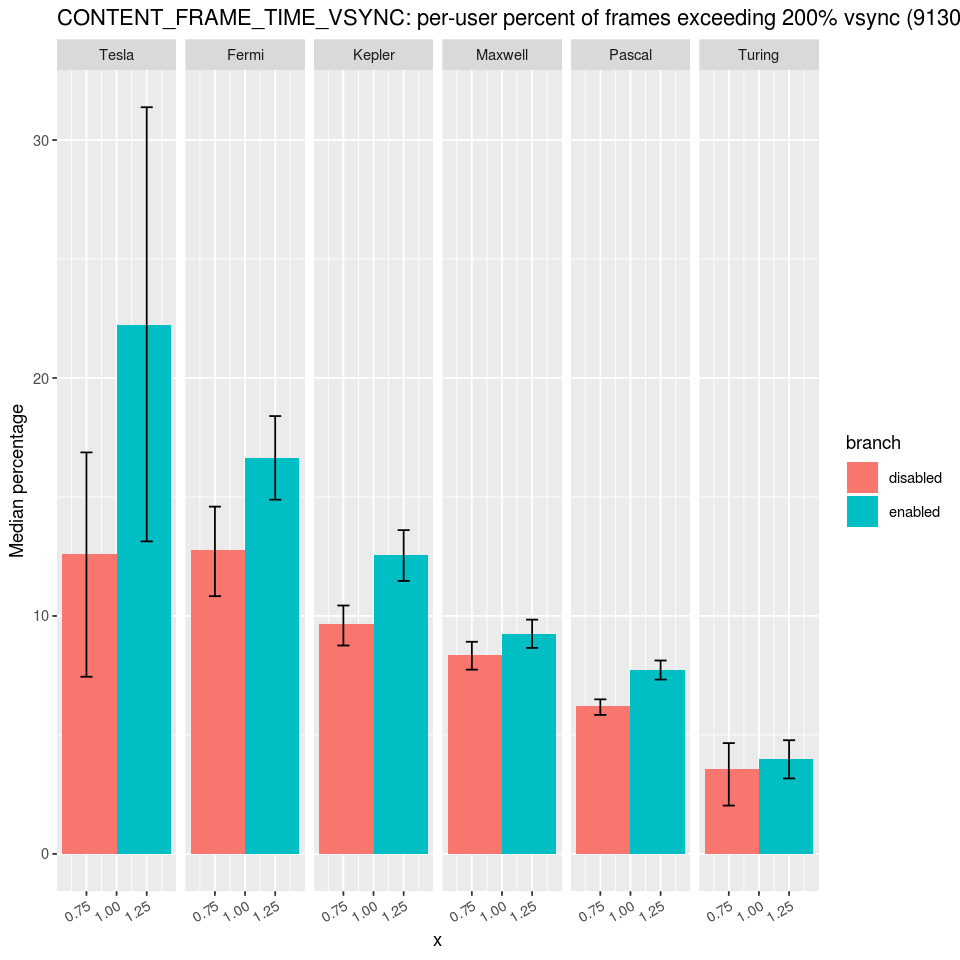

In [38]:
%r
slow_content_frame_time_vsync_total_summary %>%
  #inner_join(display_builds) %>%
  ggplot(aes(1, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~factor(gen, levels=c("Tesla", "Fermi", "Kepler", "Maxwell", "Pascal", "Turing")), scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title=sprintf("CONTENT_FRAME_TIME_VSYNC: per-user percent of frames exceeding 200%% vsync (%d users)", nrow(slow_content_frame_time_vsync)), y="Median percentage")

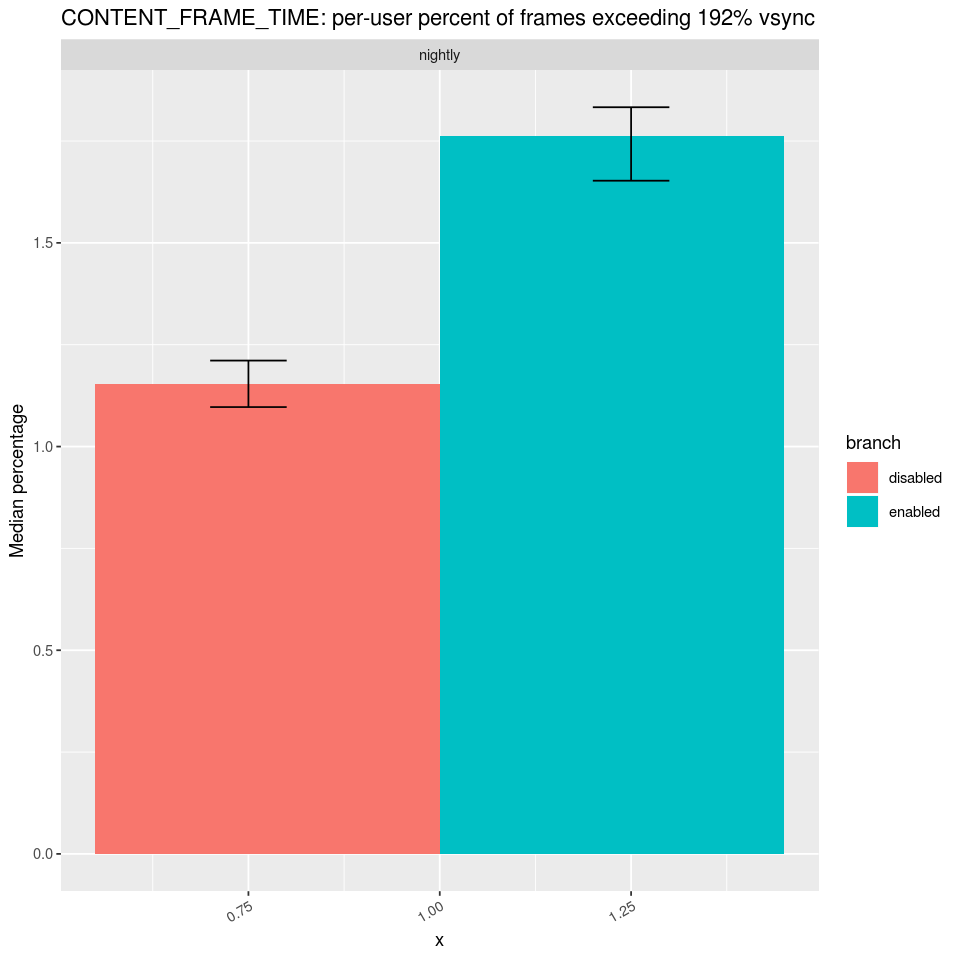

In [39]:
%r
slow_content_frame_time_total_summary %>%
  #inner_join(display_builds) %>%
  ggplot(aes(1, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME: per-user percent of frames exceeding 192% vsync", y="Median percentage")

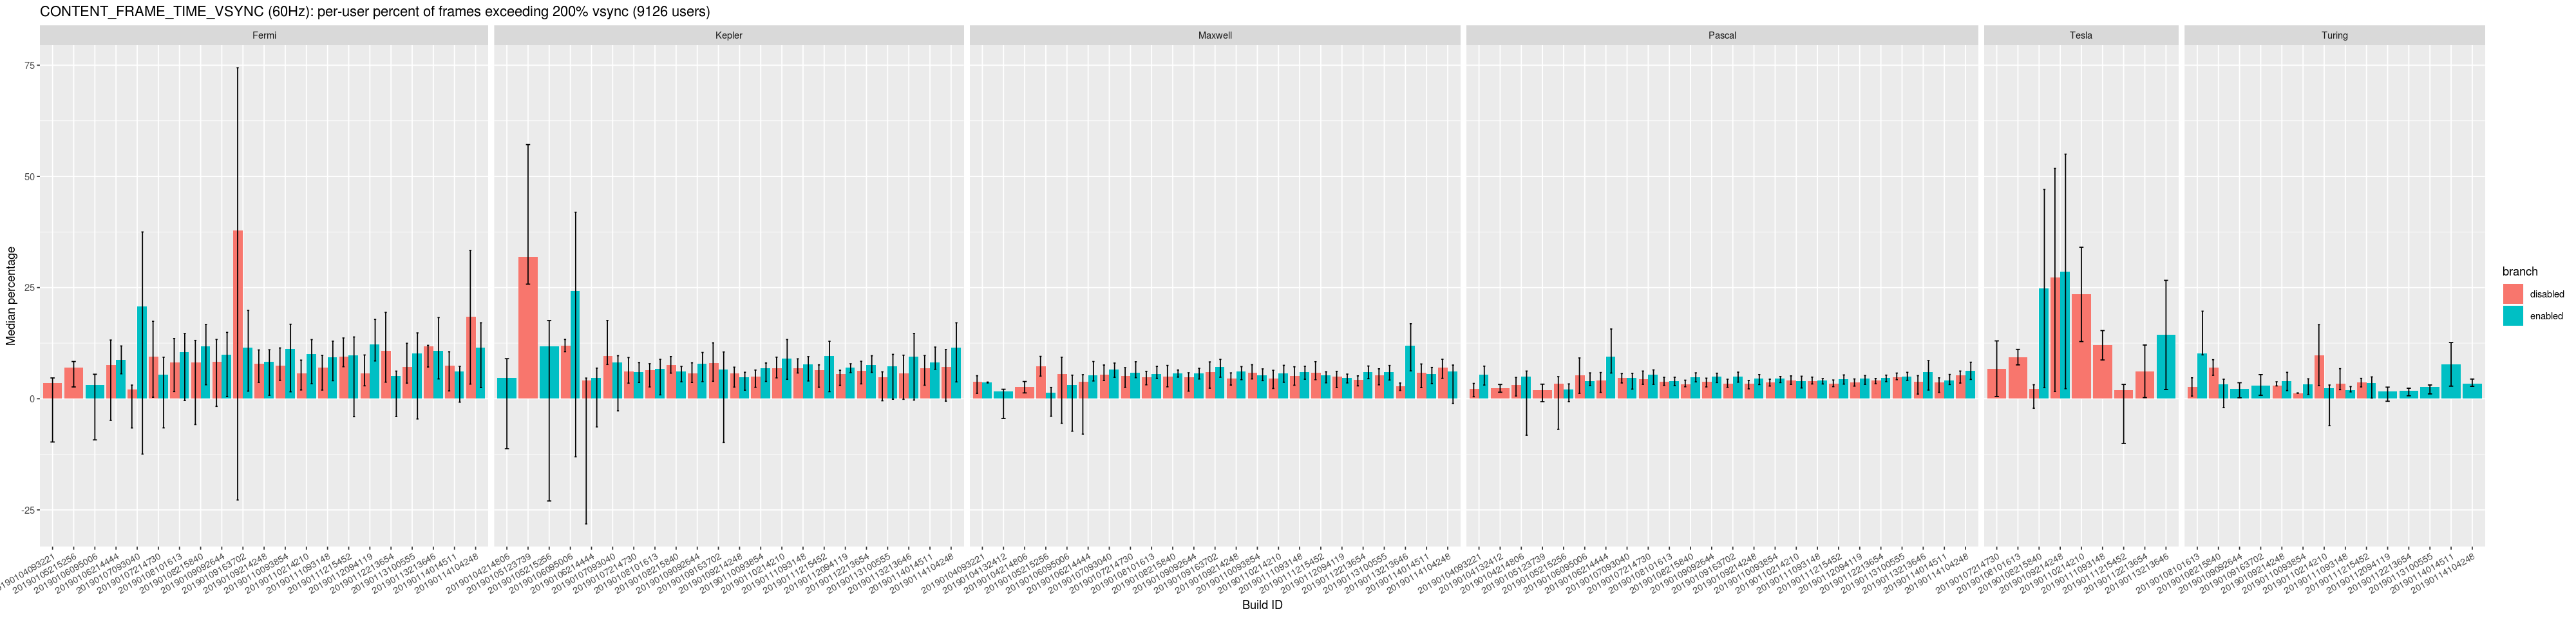

In [40]:
%r
old_width = options(repr.plot.width)
options(repr.plot.width=40000)
p <- slow_content_frame_time_vsync_summary %>%
  #inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~gen, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title=sprintf("CONTENT_FRAME_TIME_VSYNC (60Hz): per-user percent of frames exceeding 200%% vsync (%d users)", nrow(slow_content_frame_time_vsync)), x="Build ID", y="Median percentage")
options(repr.plot.width=old_width)

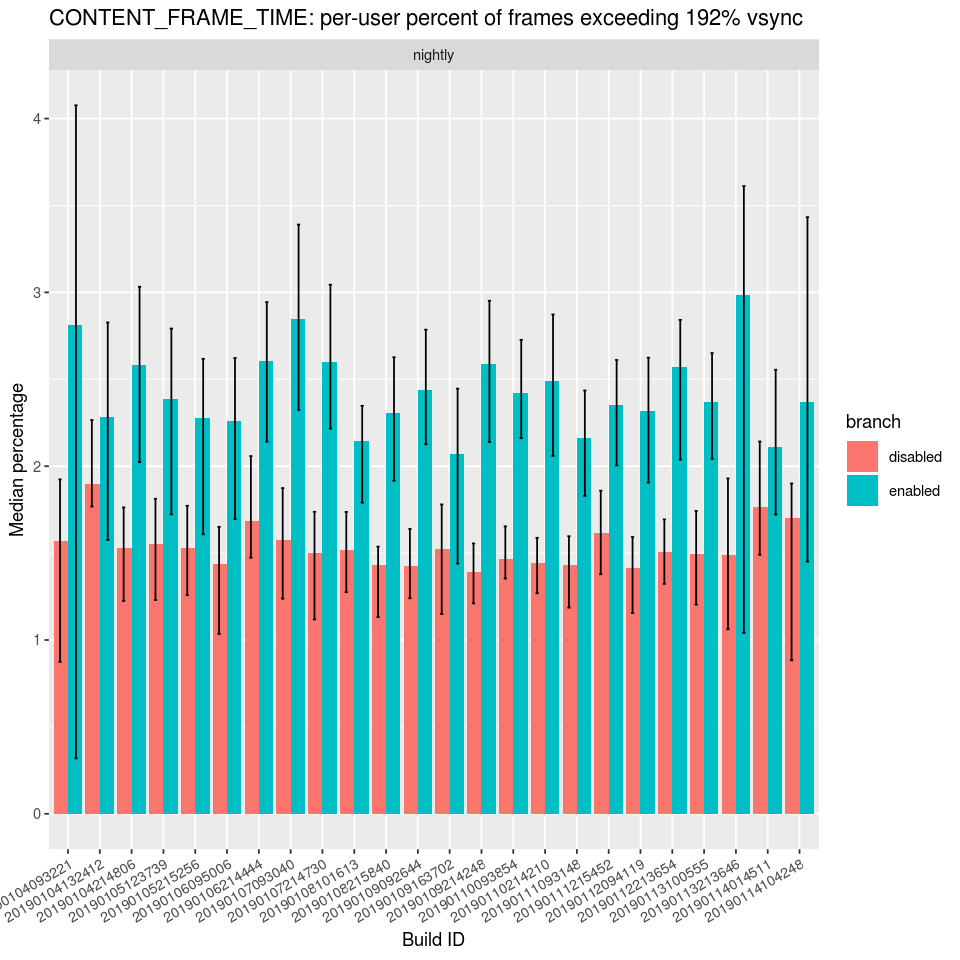

In [41]:
%r

slow_content_frame_time_summary %>%
  #inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME: per-user percent of frames exceeding 192% vsync", x="Build ID", y="Median percentage")

In [42]:
%r
slow_content_frame_time %>% filter(app_build_id == '20190104093221')

# A tibble: 77 x 6
 client_id branch app_build_id normalized_chan… threshold fraction_exceed…
 
 1 c3b92be2-82… enabl… 20190104093… nightly 192 0.0734 
 2 4fcb4af6-bd… enabl… 20190104093… nightly 192 0.0158 
 3 ce0990f4-f5… disab… 20190104093… nightly 192 0.00175
 4 a7254d6a-5a… enabl… 20190104093… nightly 192 0.00425
 5 c494aa61-ca… disab… 20190104093… nightly 192 0.0130 
 6 68d229b1-19… disab… 20190104093… nightly 192 0.0600 
 7 b5d8bb01-28… disab… 20190104093… nightly 192 0.0166 
 8 5c702947-3a… enabl… 20190104093… nightly 192 0.112 
 9 d58810b6-76… enabl… 20190104093… nightly 192 0.00495
10 d312e828-0f… disab… 20190104093… nightly 192 0.0231 
# ... with 67 more rows

In [43]:
%r
joined <- slow_content_frame_time %>% filter(app_build_id == '20190104093221') %>% inner_join(slow_content_frame_time_vsync, by=c('app_build_id', 'branch', 'client_id', 'normalized_channel'), suffix=c('192', 'vsync')) %>% select(branch, fraction_exceeding192, fraction_exceedingvsync)
joined %>% arrange(branch,fraction_exceeding192)

# A tibble: 77 x 3
 branch fraction_exceeding192 fraction_exceedingvsync
 
 1 disabled 0.00175 0.00956
 2 disabled 0.00265 0.0103 
 3 disabled 0.00319 0.00910
 4 disabled 0.00319 0.0274 
 5 disabled 0.00325 0.0221 
 6 disabled 0.00347 0.0216 
 7 disabled 0.00401 0.0165 
 8 disabled 0.00518 0.0212 
 9 disabled 0.00548 0.0422 
10 disabled 0.00782 0.0645 
# ... with 67 more rows

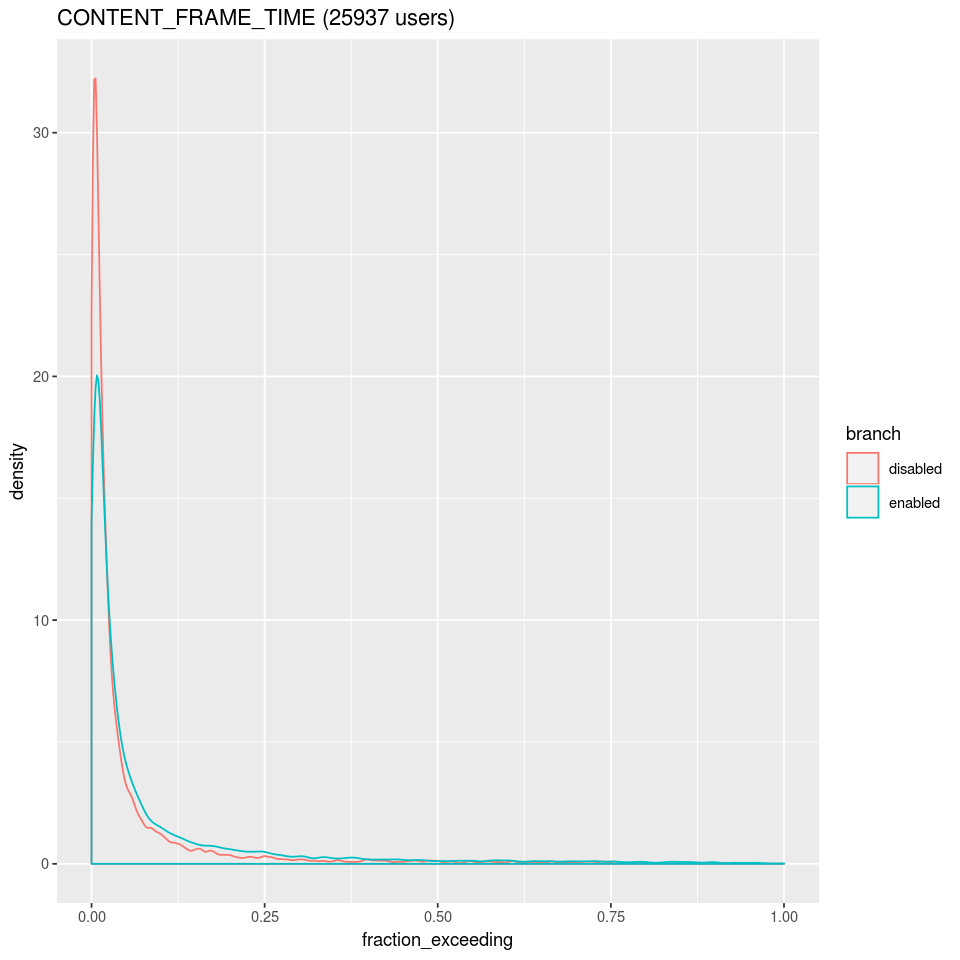

In [44]:
%r
slow_content_frame_time %>% ggplot(aes(x=fraction_exceeding, color=branch)) + geom_density() + labs(title=sprintf("CONTENT_FRAME_TIME (%d users)", nrow(slow_content_frame_time)))

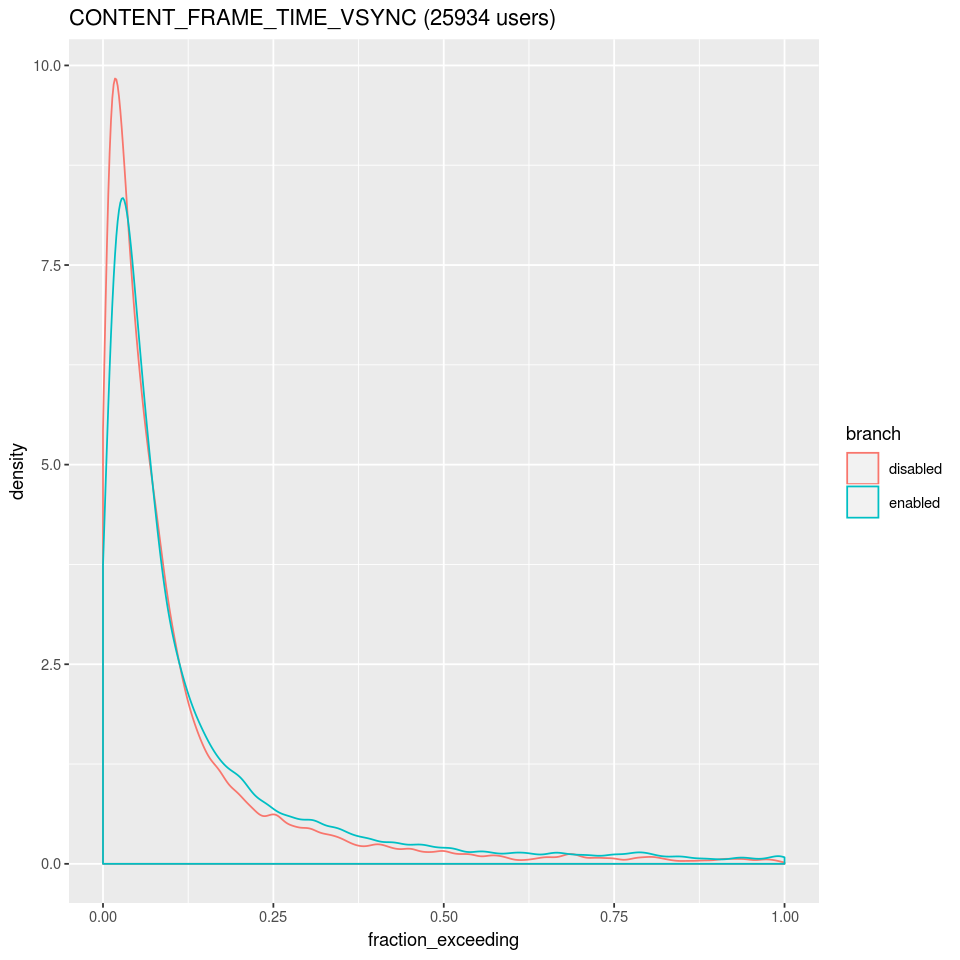

In [45]:
%r
slow_content_frame_time_vsync %>% ggplot(aes(x=fraction_exceeding, color=branch)) + geom_density() + labs(title=sprintf("CONTENT_FRAME_TIME_VSYNC (%d users)", nrow(slow_content_frame_time_vsync)))

In [46]:
%r
slow_content_frame_time %>% filter(app_build_id == '20190104093221') %>% filter(branch == 'enabled') %>% summary

client_id branch app_build_id normalized_channel
 Length:44 Length:44 Length:44 Length:44 
 Class :character Class :character Class :character Class :character 
 Mode :character Mode :character Mode :character Mode :character 
 
 
 
 threshold fraction_exceeding 
 Min. :192 Min. :0.0004654 
 1st Qu.:192 1st Qu.:0.0119995 
 Median :192 Median :0.0281412 
 Mean :192 Mean :0.0558194 
 3rd Qu.:192 3rd Qu.:0.0791488 
 Max. :192 Max. :0.2993783

In [47]:
%r
slow_content_frame_time %>% filter(app_build_id == '20190104093221') %>% filter(branch == 'disabled') %>% summary

client_id branch app_build_id normalized_channel
 Length:33 Length:33 Length:33 Length:33 
 Class :character Class :character Class :character Class :character 
 Mode :character Mode :character Mode :character Mode :character 
 
 
 
 threshold fraction_exceeding
 Min. :192 Min. :0.001746 
 1st Qu.:192 1st Qu.:0.005481 
 Median :192 Median :0.015723 
 Mean :192 Mean :0.031524 
 3rd Qu.:192 3rd Qu.:0.024150 
 Max. :192 Max. :0.241045

In [48]:
%r
  summarize_slow = function(df) {
    mystat = function(data, indices) {
      sample = data[indices,]
      median(sample[sample$branch == "enabled",]$fraction_exceeding, na.rm=TRUE) / median(sample[sample$branch == "disabled",]$fraction_exceeding, na.rm=TRUE)
    }

    ci = df %>%
      boot(mystat, 200, strata=factor(df$branch)) %>%
      boot.ci(0.95, type="basic")
    data.frame(
      ymin=ci$basic[4],
      y=ci$t0,
      ymax=ci$basic[5]
    ) * 100
  }
bind_rows(summarize_slow(slow_content_frame_time) %>% mutate(metric="slow_content_frame_time"),
          summarize_slow(slow_content_frame_time_vsync) %>% mutate(metric="slow_content_frame_time_vsync")) %>%
  select(metric, ymin, y, ymax)


metric ymin y ymax
1 slow_content_frame_time 151.0509 159.6090 167.2031
2 slow_content_frame_time_vsync 113.3104 118.4178 122.7924

In [49]:
%r
slow_content_frame_boot_p90 = function(df) {
  ci = boot(df$fraction_exceeding, function(data, x) quantile(data[x], 0.9, na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}

slow_content_frame_time_summary_p90 = slow_content_frame_time %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot_p90(.))